# Training a Neural Network
The neural networks have to have at *least **one activation function** which is **non-linear** *.  
At the beginning of the training, the network is naive and it does several mistakes: it does not know the function mapping the input to the output. Then, by adjusting its weights, the network is able to learn the correct function between the input and the output.  
To know how is going our network, we have to define a loss function (we have that the division by 2 is only for deleting the 2 coming from the derivative of the power 2 in the loss fucntion):
$$
\large \ell = \frac{1}{2n}\sum_{i=1}^n{\left(y_i - \hat{y}_i\right)^2},
$$
where $n$ is the *number of training examples*, $y_i$ are the *true labels*, and $\hat{y}_i$ are the *predicted labels*.  
This is named **mean squared loss** which is fine for:  
1. **regression problems**  
2. **binary classification problems**  
  
By *minimizing this loss w.r.t. the parameters of the networks* (the biases and the weights) we find the best configuration of the parameters that are such that they give the minimum error, thus the maximum accuracy.

## Losses in PyTorch
The module `nn` provides *different types of loss*, as the *Cross Entropy Loss* `nn.CrossEntropyLoss`. The type of loss to compute in general is assigned to a parameter called `criterion`. When using a the *Softmax function* as the *activation function of the output layer*, generally, as *loss function* is used the *Cross Entropy Loss*.  
  
Something really important to point out is that the `nn.CrossEntropyLoss` combines two functions `nn.LogSoftmax` and `nn.NLLLoss` into a single class.  
Note that the **input to such a function needs to have the scores for each class**.  
  
This means that we have to pass *the output of the output layer before it passes through the Softmax function*.  
Such raw output is often called:  
1. *logits*  
2. *scores*  
  
This representation is used because the floating point numbers cannot represent well the numbers near 0 or near 1, more details [here](https://docs.python.org/3/tutorial/floatingpoint.html). Generally speaking, it is not good to make computations with probabilities and often we use the log of the probabilities.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Load the training data
trainset = datasets.MNIST('./MNIST', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [2]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
# We ask for an iterator
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits/scores, so the values
# which are not in the range of probabilities
logits = model(images)

# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2904, grad_fn=<NllLossBackward>)


As said, it is better to use the log on the probabilities to do the computations (over the logits/scores, we compute the probabilities thanks to the SoftMax function, and then we do the log). So, to use `nn.LogSoftmax` or `F.log_softmax`.  
Then, we can take the probabilities, by taking the exponential of the output: `toch.exp(output)`.  
With the `nn.LogSoftmax` output ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)), we want to use the Negative Log-Likelihood Loss function `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).  
Note that when applying a `nn.SoftMax` or a `nn.LogSoftMax` we have to specify the dimension over which we apply it (generally it is the second dimension because in the second dimension we have the output: all the classes).

In [3]:
# TODO: Build a feed-forward network
model =  nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# TODO: Define the loss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logodds = model(images)

# Calculate the loss with the logits and the labels
loss = criterion(logodds, labels)

print(loss)

tensor(2.3093, grad_fn=<NllLossBackward>)


# Autograd
Now, we know how to compute the loss and we want to compute the gradient.  
PyTorch has a module which is able to compute the gradient `autograd` which automatically computes the gradient on the tensors. In order to enable this option we have to set the parameter `requires_grad = True`. This option can be set in:
- the parameter `criterion`  
- defining a tensor.  
  
If we want to disable this option for a specific tensor we have to use `torch.no_grad()`, as follows:  
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```
Also, you can turn on/off the gradients computation thanks to:  
`torch.set_grad_enabled(True|False)`  
The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.  
Indeed, we will use this function when we will do the back propagation of the loss.

In [4]:
x = torch.randn(2,2, requires_grad=True)# we give the number of rows and the number of columns
print(x)

tensor([[-0.1006, -1.5891],
        [-0.4009, -2.1259]], requires_grad=True)


In [5]:
y = x**2
print(y)

tensor([[0.0101, 2.5253],
        [0.1608, 4.5196]], grad_fn=<PowBackward0>)


Below we can see the operation that created y, a power operation `PowBackward0`.

In [6]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to anyone tensor. Let's reduce the tensor y to a scalar value, the mean.

In [7]:
z = y.mean()
print(z)

tensor(1.8039, grad_fn=<MeanBackward0>)


In [8]:
print(x.grad)

None


You can see that the gradient of x is `None`, because it is computed only when we call `.backward` method on a variable, `z` with respect to `x`.  
$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [9]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.0503, -0.7946],
        [-0.2005, -1.0630]])
tensor([[-0.0503, -0.7946],
        [-0.2005, -1.0630]], grad_fn=<DivBackward0>)


## Loss and Autograd togheter
When in *PyTorch we create a neural network* all the *parameters are initialized with `requires_grad=True`*. Thus, when we calculate the loss we call `loss.backward()`, the gradients for the parameters are calculated. Such *gradients are used to update the weights when computing the gradient descent*.

In [10]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [11]:
print('Before backward pass: \n', model[0].weight.grad) # we ask the gradient w.r.t. what it is computed

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0047,  0.0047,  0.0047,  ...,  0.0047,  0.0047,  0.0047],
        [-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017],
        [ 0.0019,  0.0019,  0.0019,  ...,  0.0019,  0.0019,  0.0019],
        ...,
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [-0.0026, -0.0026, -0.0026,  ..., -0.0026, -0.0026, -0.0026]])


# Training the Network
The final thing that we need to train our network is an *optimizer which will be used to update the weights with the gradients*. There is an apposite PyTorch package with optimizers: [`torch.optim`](https://pytorch.org/docs/stable/optim.html). For example, we use the **Stochastic Gradient Descent** with `optim.SGD`.

In [12]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

The general process with PyTorch is:  
1. Make a forward pass  
2. Use the network loss to compute the gradient  
3. Perform the baclward pass through the network with `loss.backward()` to calculate the gradients  
4. Take a step with the optimizer to update the weights  

Below it is done one only training step and print out the weights and gradients. There is also the following line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [13]:
print('Initial weights - ', model[0].weight)

dataiter = iter(trainloader)
images, labels = next(dataiter)
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 2.4164e-02, -2.3862e-03, -2.3992e-02,  ..., -2.3034e-02,
         -2.0844e-02,  8.8906e-03],
        [-3.2069e-02,  1.7716e-02,  2.2646e-05,  ..., -1.0739e-02,
          3.5666e-02,  1.3584e-02],
        [ 2.0075e-02, -2.9326e-02, -2.4595e-03,  ...,  1.8667e-02,
         -9.0029e-03,  1.0059e-02],
        ...,
        [ 1.1459e-02,  2.7546e-02,  4.0567e-03,  ..., -2.0995e-02,
         -2.6201e-02,  1.2848e-02],
        [ 3.3757e-03, -7.9914e-03, -3.2958e-02,  ...,  1.6433e-02,
          9.4524e-03,  2.7470e-02],
        [ 2.6429e-02,  1.4310e-02, -6.7004e-03,  ..., -3.2211e-02,
         -1.8279e-02, -3.3115e-02]], requires_grad=True)
Gradient - tensor([[ 0.0052,  0.0052,  0.0052,  ...,  0.0052,  0.0052,  0.0052],
        [ 0.0032,  0.0032,  0.0032,  ...,  0.0032,  0.0032,  0.0032],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        ...,
        [-0.0035, -0.0035, -0.0035,  ..., -0.0035, -0.0035, -0.0035],
   

In [15]:
# Take an update step and view the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0295,  0.0337, -0.0247,  ...,  0.0134, -0.0250, -0.0153],
        [-0.0160,  0.0135, -0.0189,  ..., -0.0153,  0.0285, -0.0058],
        [ 0.0238, -0.0336, -0.0324,  ..., -0.0172,  0.0215,  0.0136],
        ...,
        [-0.0126,  0.0245, -0.0328,  ...,  0.0115, -0.0116, -0.0015],
        [ 0.0252,  0.0288,  0.0140,  ...,  0.0201,  0.0005, -0.0081],
        [-0.0314, -0.0220,  0.0036,  ..., -0.0157, -0.0039, -0.0180]],
       requires_grad=True)


## Training for real
Now, we pass through all the images whose operation is called an *epoch*. So, we train through `trainloader` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backward pass, and update the weights.

In [14]:
## Your solution here

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1)) # this means that we want that the columns sum up to 1

criterion = nn.NLLLoss()# Negative Log Lihelihood Loss
optimizer = optim.SGD(model.parameters(), lr=0.003)# Stochastic Gradient Descent method to compute the back propagation

epochs = 5
for e in range(epochs):# we are doing 5 epochs
    running_loss = 0
    # we are passing all the images in one batch
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 (1x28x28) long vector
        # we give the only dimension to retain
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass

        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        # we do a forward pass, then backward pass and then update weights for each batch
        # of images
        output = model(images)
        # we had defined the criterion to compute the loss
        # in the previous lines
        loss = criterion(output, labels)
        # we compute the gradient with a backward pass
        loss.backward()        
        # we update the weights thanks to the optimizer
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")


Training loss: 1.9390675222187408
Training loss: 0.9033951581096344
Training loss: 0.5398348900936306
Training loss: 0.44120867099207856
Training loss: 0.3959719531539915


Now, we have a trained network and we can use it to make predictions.

tensor([[9.3812e-01, 1.2429e-07, 5.7075e-03, 1.6808e-02, 4.9305e-05, 3.4370e-02,
         2.1404e-04, 5.9288e-05, 4.3045e-03, 3.7122e-04]])


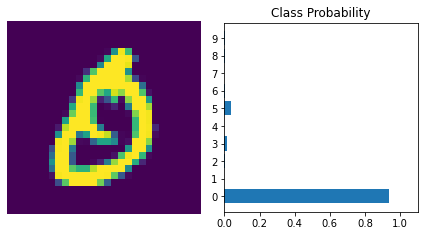

In [17]:
# the following was for making functioning the library matplotlib
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
import helper # ah help file for beautiful plots

dataiter = iter(trainloader)
images, labels = next(dataiter)

# we flatten an image
img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
print(ps)
# to the helper function we pass the dimension of the image and the probabilities for the image
helper.view_classify(img.view(1, 28, 28), ps)